Video was given from https://motchallenge.net/vis/MOT16-04

In [30]:
# !pip install distinctipy==1.2.2 filterpy==1.4.5 lap==0.4.0 -q

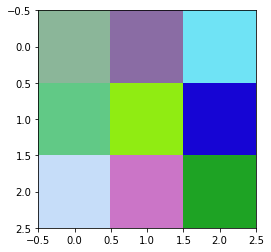

In [1]:
import torch
import cv2
import numpy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sort import Sort
import distinctipy

sample_img = np.random.rand(3,3,3)
plt.imshow(sample_img)

In [2]:
device = 'cuda:0'

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True).to(device)
model.float()
model.eval()
1

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-22 Python-3.8.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 


1

In [4]:
from pathlib import Path

data_dir = Path('data')

reference_vid = data_dir / 'ref_vid.mp4'

save_to = data_dir / 'hungurian_baseline_results' / reference_vid.stem
save_to.mkdir(exist_ok=True, parents=True)

In [5]:
mot_tracker = Sort()

In [63]:
! rm -rf /app/notebooks/object_tracking/data/hungurian_baseline_results/ref_vid/*

In [41]:
iou = torch.rand(5,6)
iou.min(), iou.max()

(tensor(0.01501), tensor(0.91636))

In [42]:
iou

tensor([[0.79100, 0.07926, 0.43298, 0.58862, 0.23955, 0.26699],
        [0.86151, 0.74992, 0.15727, 0.59859, 0.77498, 0.15379],
        [0.87713, 0.41904, 0.83314, 0.37887, 0.77767, 0.16067],
        [0.33383, 0.80378, 0.08917, 0.15110, 0.01501, 0.26593],
        [0.02479, 0.55631, 0.91636, 0.57197, 0.03458, 0.60029]])

In [64]:
import torch
from torchvision.ops import box_iou
from scipy.optimize import linear_sum_assignment

def hungarian_match(bboxs1, bboxs2, min_iou = 0.3):
    """
    bboxs1: m x 4
    bboxs2: n x 4
    returns: m x 1
    """
    ious = box_iou(bboxs1,bboxs2).cpu().numpy()
    row_ind, col_ind = linear_sum_assignment(-ious)
    
    new_row_ind, new_col_ind = [], []
    
    for m in zip(row_ind, col_ind):
        if(ious[m[0], m[1]]>=min_iou):
            new_row_ind.append(m[0])
            new_col_ind.append(m[1])
    
    return np.array(new_row_ind), np.array(new_col_ind)

def color_t(idx):
    state = np.random.get_state()
    numpy.random.seed(seed=idx)
    val = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
    np.random.set_state(state)
    return val

def update_trackers(trackers, detections, max_idx):
    """
    trackers - objects that we currently tracking
    detections - not yet classified bboxes that detected on new frame
    
    From detections we want to understand few things:
    1. Who is new to trackers?
    2. Who is lost from trackers?
    """
    if len(trackers) == 0: 
        trks_inds = torch.arange(len(detections)).unsqueeze(-1).to(device)
        return torch.cat([detections, trks_inds], dim=-1), 0
    
    max_id = trackers[..., 4].max().item()
    
    max_id = max(max_id, max_idx)
    
    row_ind, col_ind = hungarian_match(trackers[..., :4], detections)
    
    new_detection_ind = set(range(len(detections))) - set(col_ind) 
    
    tracked_ind = set(row_ind)
    
    trackers[list(row_ind), :4] = detections[list(col_ind)]
    trackers = trackers[list(tracked_ind)]
    
    new_detected = detections[list(new_detection_ind)]
    new_trackers_inds = torch.arange(max_id+1, max_id+len(new_detected)+1).unsqueeze(-1).to(device)
    new_trackers = torch.cat([new_detected,new_trackers_inds], dim=-1)
    
    trackers = torch.cat([trackers, new_trackers], dim=0)
    
    return trackers, max_id+len(new_detected)+1

In [65]:
file = str(reference_vid)
verbose = True

capture = cv2.VideoCapture(file)
fps = capture.get(cv2.CAP_PROP_FPS)
n_frames = capture.get(cv2.CAP_PROP_FRAME_COUNT)

bbs_ids_frame_count = {}

frames = []

track_bbs_ids = []
max_trackers_id = 0

pb = np.arange(n_frames)
if verbose:
    pb = tqdm(pb)

for i in pb:
    success, image_cv = capture.read()
    if i > 270: break # TODO: remove this line
    
    if not success:
        break

    preds = model(image_cv)
    detections = preds.pred[0][..., :4]
    track_bbs_ids, max_trackers_id = update_trackers(track_bbs_ids, detections, max_trackers_id)
    
    for j in range(len(track_bbs_ids)):
        coords = track_bbs_ids[j]
        x1, y1, x2, y2 = int(coords[0]), int(coords[1]), int(coords[2]), int(coords[3])
        
        name_idx = int(coords[4])
        
        if name_idx in bbs_ids_frame_count.keys():
            bbs_ids_frame_count[name_idx] += 1
        else:
            bbs_ids_frame_count[name_idx] = 1
            
        sec_per_id = bbs_ids_frame_count[name_idx] / fps
            
        name = f"ID:{name_idx}|T:{sec_per_id:.2f}s"
        color = color_t(name_idx)
        
        cv2.rectangle(image_cv, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image_cv, name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        cv2.imwrite(str(save_to / f"{int(i)}.png"), image_cv)
        # plt.imshow(image_cv)
        # plt.show()
        
    # if i % frame_read_freq == 0:
    #     frame = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
    #     frame = torch.tensor(frame/255, dtype=torch.float32)
    #     frames.append(frame.permute(2,0,1)[None])

 26%|████████████████████████████████▎                                                                                            | 271/1050 [03:22<09:43,  1.34it/s]


# Save video

In [44]:
# !pip install moviepy --upgrade
!pip install ffmpeg --upgrade

In [66]:
import cv2
import os

image_folder = str(save_to)
video_name = 'video_hungarian.mp4'
fps = 30

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
sorted_img_ids = sorted([int(i.split('.')[0]) for i in images])
images = [f"{i}.png" for i in sorted_img_ids]

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
video = cv2.VideoWriter(video_name, fourcc, fps, (width,height))

for image in tqdm(images):
    video.write(cv2.imread(os.path.join(image_folder, image)))

video.release()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:04<00:00, 62.19it/s]
